In [404]:
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from xgboost import XGBClassifier

In [357]:
dtrain = pd.read_csv('churn_train.csv')
dtest = pd.read_csv('churn_test.csv')

In [358]:
dtrain.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,1768-ZAIFU,Female,1,No,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,25.20,25.2,Yes
1,2159-TURXX,Male,0,No,No,5,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Credit card (automatic),20.05,95.55,No
2,8261-GWDBQ,Female,1,Yes,No,60,Yes,Yes,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),116.05,6925.9,No
3,2732-ISEZX,Female,0,No,No,5,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Mailed check,20.50,104.3,No
4,7607-QKKTJ,Male,0,Yes,Yes,45,Yes,Yes,Fiber optic,No,...,Yes,No,No,Yes,One year,Yes,Credit card (automatic),95.00,4368.85,No


In [359]:
dtest.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,9505-SQFSW,Female,0,Yes,Yes,3,No,No phone service,DSL,No,...,No,No,No,Yes,Month-to-month,No,Mailed check,40.30,92.5,No
1,1723-HKXJQ,Male,0,No,No,42,Yes,Yes,Fiber optic,No,...,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,101.75,4273.45,Yes
2,9154-QDGTH,Male,0,Yes,Yes,43,Yes,Yes,Fiber optic,No,...,Yes,Yes,Yes,Yes,One year,Yes,Credit card (automatic),104.30,4451.85,No
3,8309-IEYJD,Female,1,No,No,1,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,70.60,70.6,No
4,8775-CEBBJ,Female,0,No,No,9,Yes,No,DSL,No,...,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),44.20,403.35,Yes


In [360]:
dtrain.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

## För det första behöver vi omvandla strängkolumnar till dtype kattegorier

# Analusering av datan

In [175]:
churn_counts = dtrain['Churn'].unique()

In [176]:
print(churn_counts)

['Yes' 'No']


## Ska utföra analyser och beräkningar baserat på churn-kategorier och beräkna andelen churnade kunder eller utföra jämförelser mellan olika grupper baserat på churn-status.

In [353]:
def churn_frekvens(df):
    columns = df.columns
    for c in columns:
        churn = dtrain.groupby(f'{c}')['Churn'].value_counts(normalize=True).unstack()
        churn.plot(kind='bar', stacked=True)
        plt.xlabel(f'{c}')
        plt.ylabel('Andel')
        plt.title(f'Churn-frekvens efter {c}')
        plt.legend(title='Churn', loc='upper right')
    plt.show()

/Users/yari/anaconda3/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:512: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


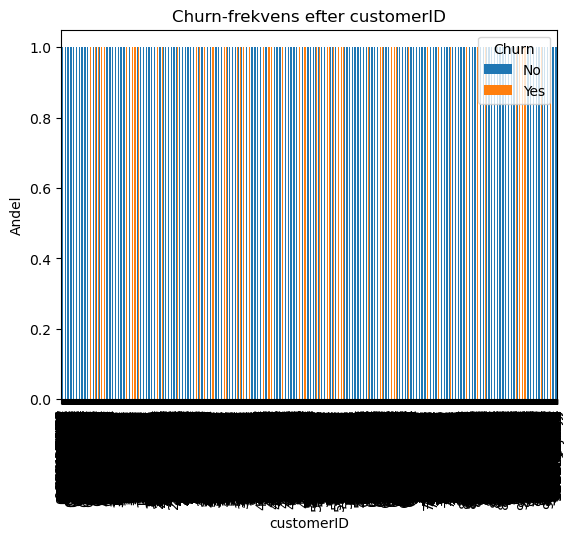

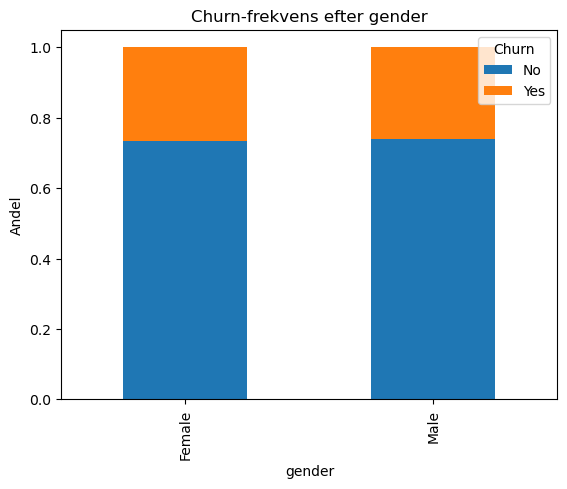

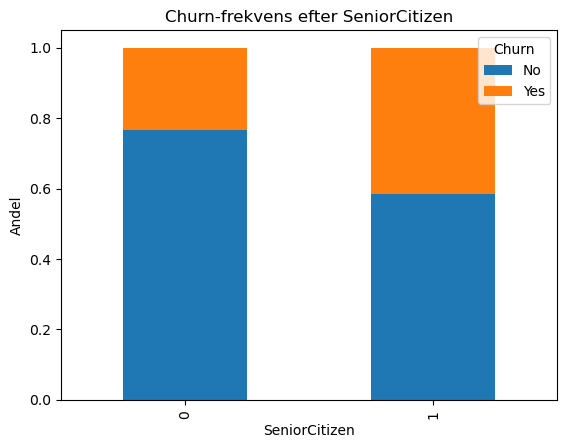

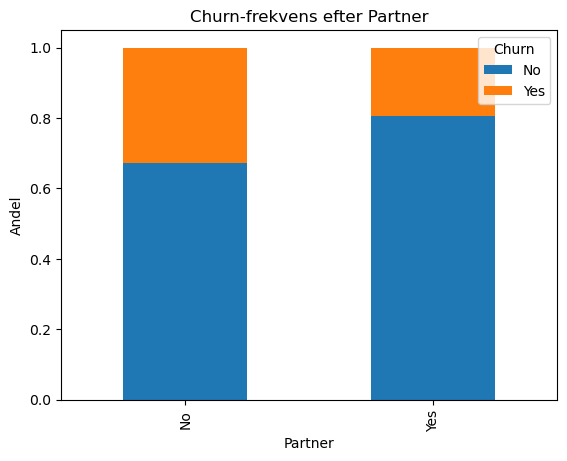

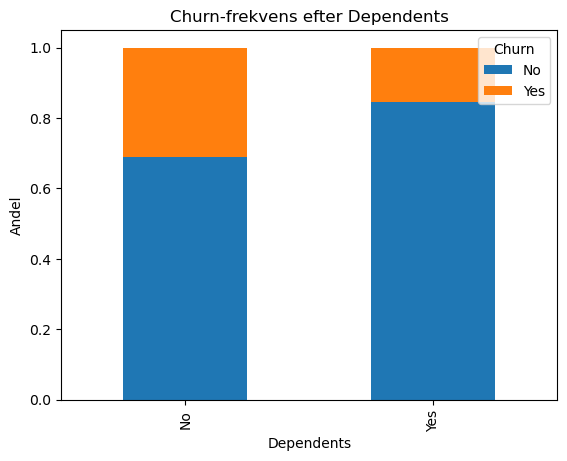

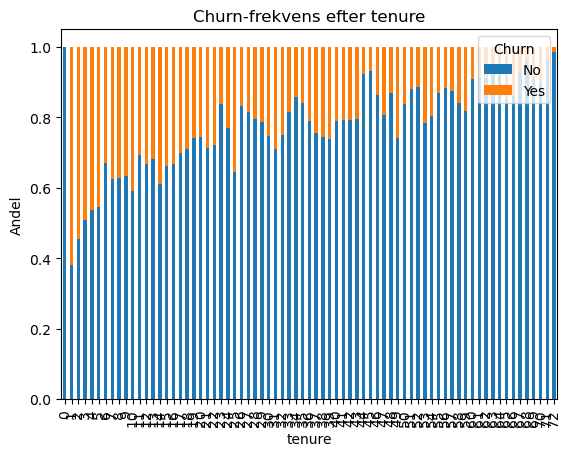

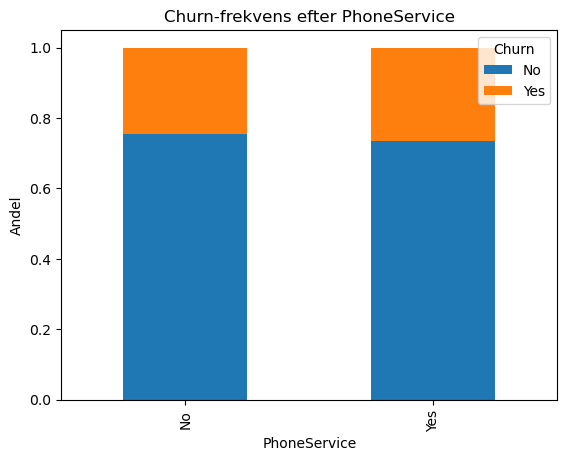

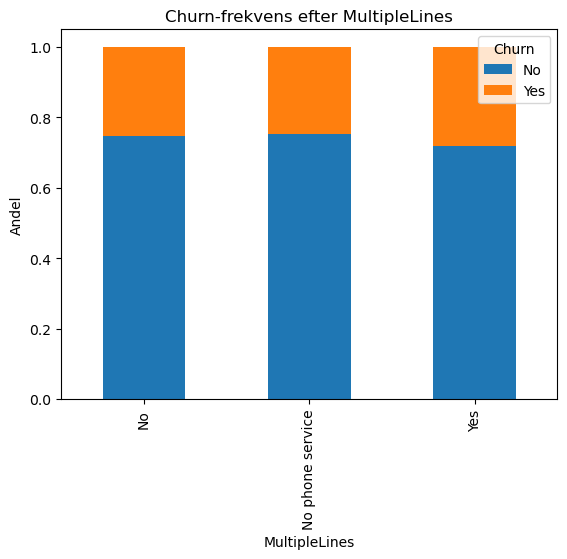

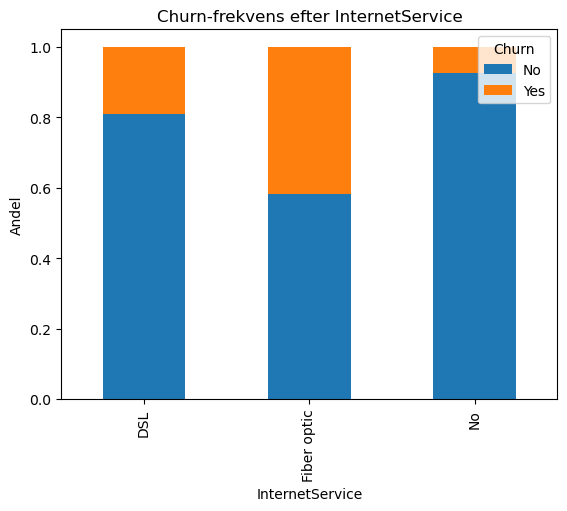

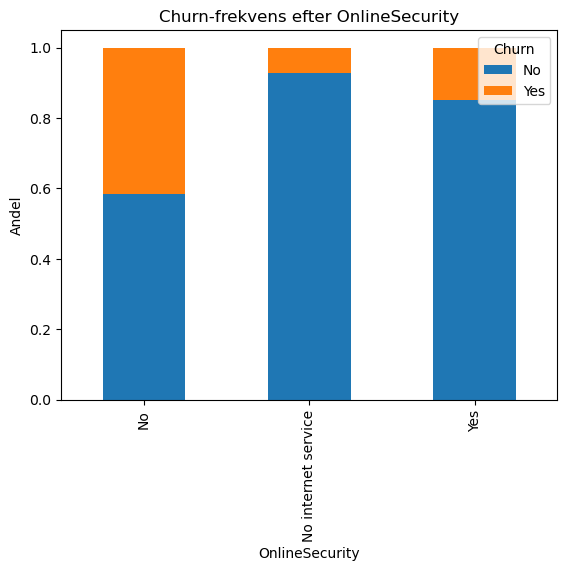

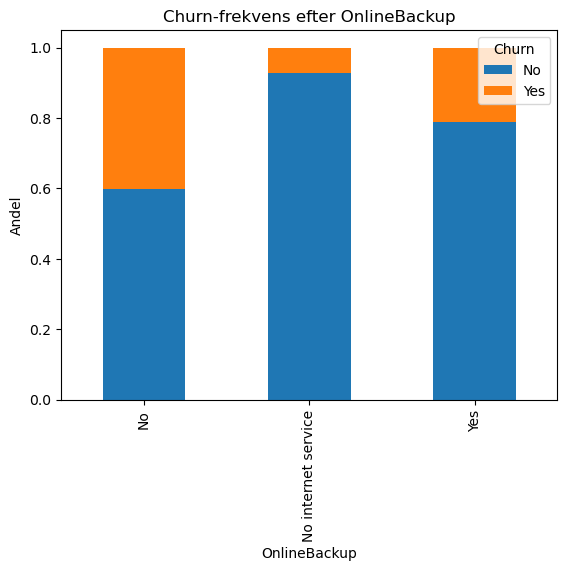

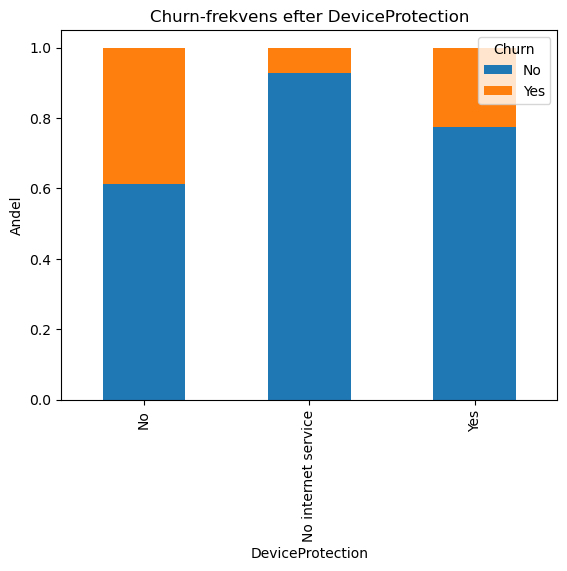

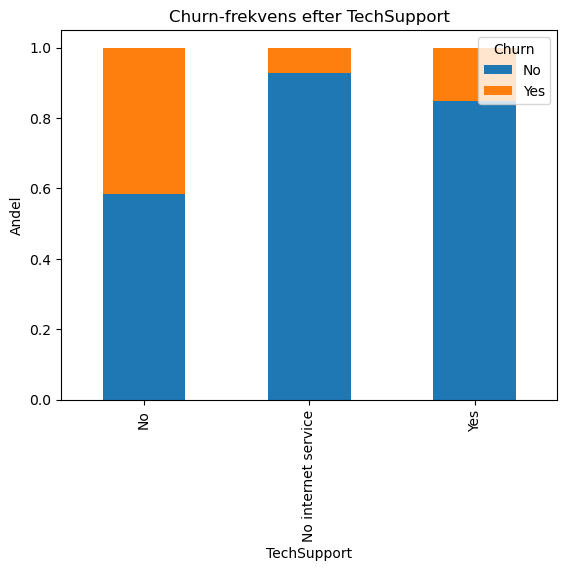

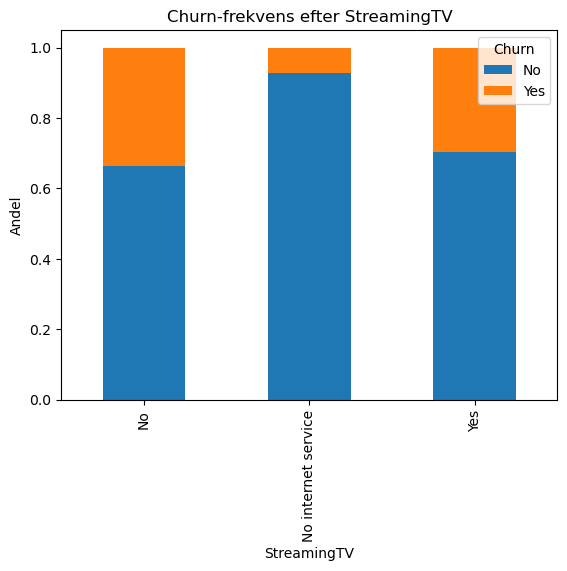

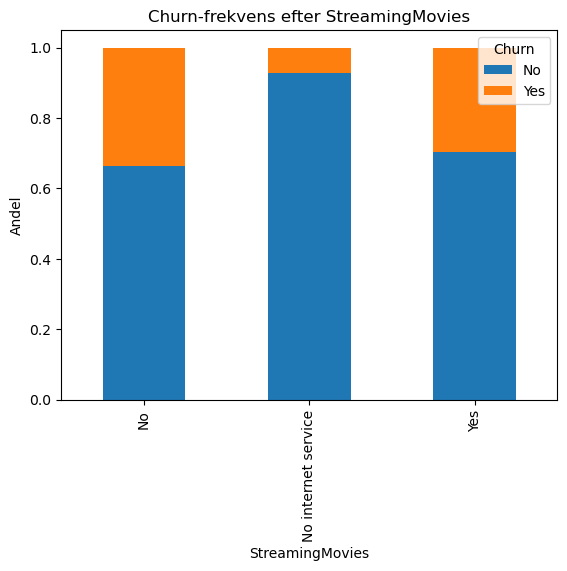

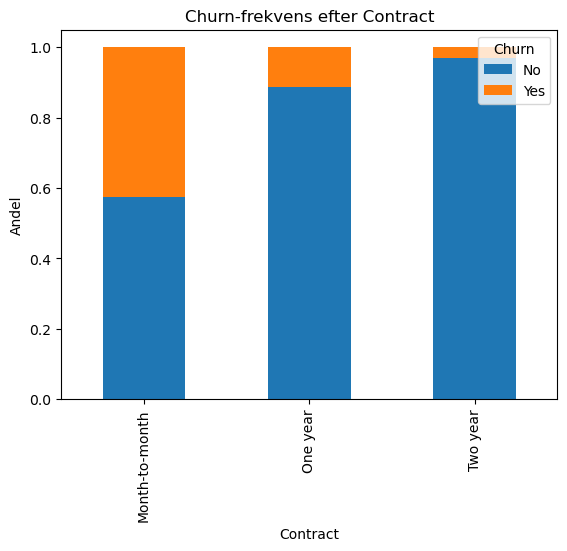

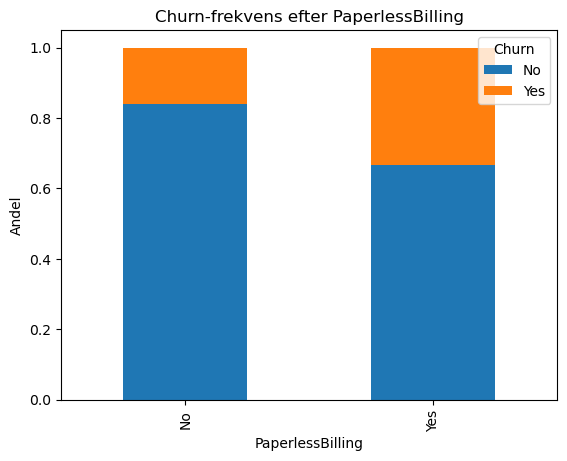

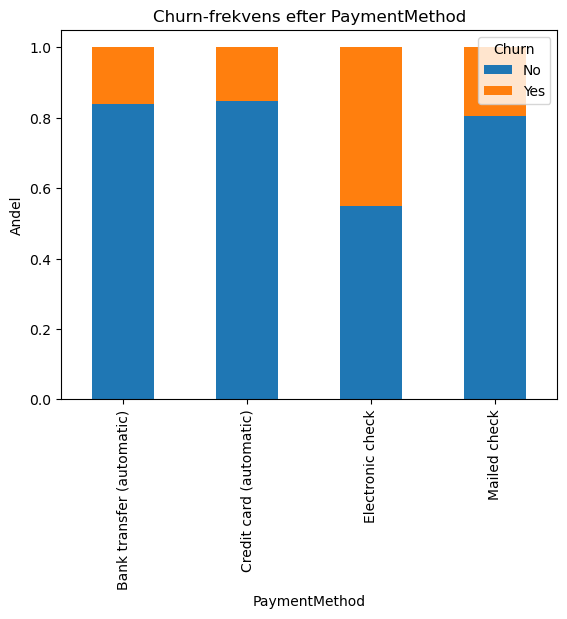

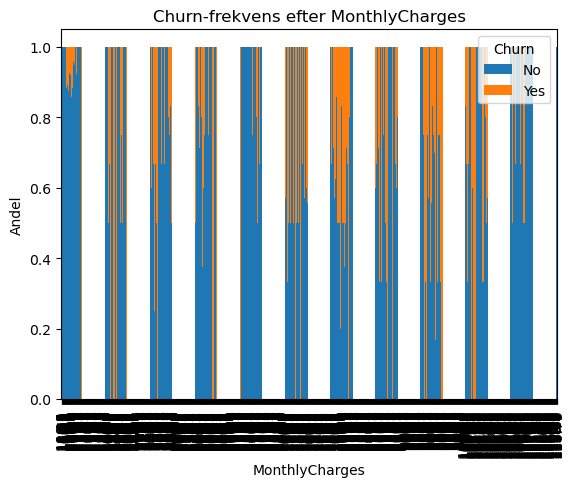

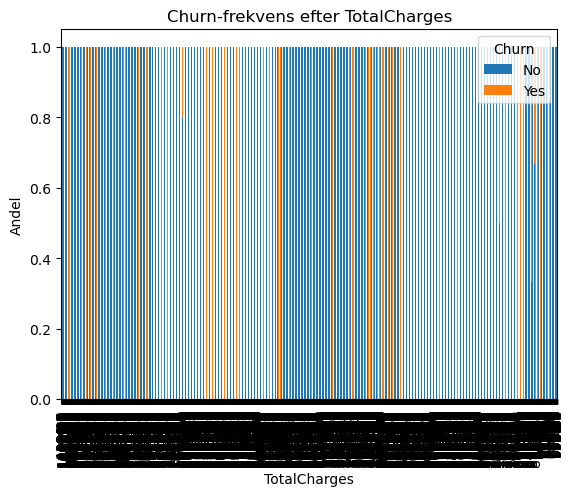

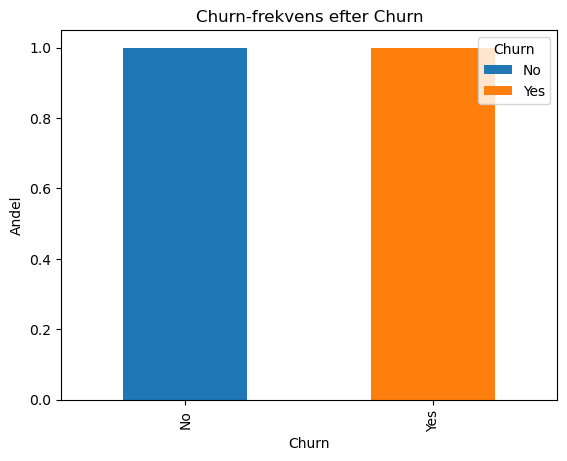

In [38]:
churn_frekvens = churn_frekvens(dtrain)

### I churn frekvens  efter varja attribut ser vi att churn-frekvensen inte verkar variera beroende på kön. Detta kan vara en intressant observation och kan indikera att kön i sig inte är en avgörande faktor för churn i detta fall.

## Hur ser fördelningen av target datan ut?

In [12]:
churn_counts = dtrain['Churn'].value_counts()

In [13]:
print(churn_counts)

No     4148
Yes    1486
Name: Churn, dtype: int64


## Antalet kunder som inte har lämnat företaget (No) är 4148, medan antalet kunder som har lämnat företaget (Yes) är 1486. Det är en betydande skillnad i antal mellan de två kategorierna.

## Denna obalans kan vara viktig att beakta när vi tränar churn-modellen. Eftersom majoriteten av kunderna inte har lämnat företaget kan modellen bli överväldigad av majoritetsklassen och kan ha svårt att korrekt identifiera de kunder som faktiskt kommer att lämna.

# Kolumnen customerID är inte till använd, så där för vill jag droppa den först och sen omvandla kolumnerna med dtype object till numerisk

In [361]:
dtrain = dtrain.drop(['customerID'], axis = 1)
dtest = dtest.drop(['customerID'], axis = 1)

In [362]:
dtrain.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,1,No,No,1,No,No phone service,DSL,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,25.20,25.2,Yes
1,Male,0,No,No,5,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,No,Credit card (automatic),20.05,95.55,No
2,Female,1,Yes,No,60,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),116.05,6925.9,No
3,Female,0,No,No,5,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Month-to-month,Yes,Mailed check,20.50,104.3,No
4,Male,0,Yes,Yes,45,Yes,Yes,Fiber optic,No,Yes,Yes,No,No,Yes,One year,Yes,Credit card (automatic),95.00,4368.85,No


In [363]:
dtest.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,Yes,3,No,No phone service,DSL,No,Yes,No,No,No,Yes,Month-to-month,No,Mailed check,40.30,92.5,No
1,Male,0,No,No,42,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,101.75,4273.45,Yes
2,Male,0,Yes,Yes,43,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,One year,Yes,Credit card (automatic),104.30,4451.85,No
3,Female,1,No,No,1,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,70.60,70.6,No
4,Female,0,No,No,9,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,Yes,Bank transfer (automatic),44.20,403.35,Yes


In [364]:
def encode_columns(df_train, df_test):
    combined_df = pd.concat([df_train, df_test])  # här ska jag kombinera traindata och testdatan för att sen kunna omvandla dem både
    columns_to_encode = combined_df.select_dtypes(include=['object']).columns
    for column in columns_to_encode:
        le = LabelEncoder()
        combined_df[column] = le.fit_transform(combined_df[column])
    
    df_train_encoded = combined_df[:len(df_train)]
    df_test_encoded = combined_df[len(df_train):]
    
    return df_train_encoded, df_test_encoded


In [365]:
df_train_encoded, df_test_encoded = encode_columns(dtrain, dtest)

In [328]:
df_train_encoded.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,2,25.20,2151,1
1,1,0,0,0,5,1,0,2,1,1,1,1,1,1,0,0,1,20.05,6444,0
2,0,1,1,0,60,1,2,1,2,2,2,2,2,2,2,1,0,116.05,5466,0
3,0,0,0,0,5,1,0,2,1,1,1,1,1,1,0,1,3,20.50,80,0
4,1,0,1,1,45,1,2,1,0,2,2,0,0,2,1,1,1,95.00,3709,0


In [396]:
df_test_encoded.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,0,0,1,1,3,0,1,0,0,2,0,0,0,2,0,0,3,40.30,6369,0
1,1,0,0,0,42,1,2,1,0,2,0,0,2,2,0,1,2,101.75,3639,1
2,1,0,1,1,43,1,2,1,0,0,2,2,2,2,1,1,1,104.30,3779,0
3,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,1,3,70.60,5513,0
4,0,0,0,0,9,1,0,0,0,0,0,0,0,0,0,1,0,44.20,3448,1


In [368]:
X_train = df_train_encoded.drop("Churn", axis=1)  
y_train = df_train_encoded["Churn"] 

In [408]:
X_test = df_test_encoded.drop("Churn", axis=1)  
y_test = df_test_encoded["Churn"]  

In [409]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [452]:
model = XGBClassifier(
    objective="binary:logistic", 
    max_depth=3,  
    learning_rate=0.1,
    seed=42
)

In [453]:
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [454]:
y_pred = model.predict(X_test)

# Accuracy Score

In [457]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy score för modellen blir: %.2f%%" % (accuracy * 100).round(1))

Accuracy score för modellen blir: 79.10%


# Analysering av modellen

## Vilka attribut som har störst påverkan

### Metod 1. med hjälp av inbyggda funktion i XGBoost-biblioteket 

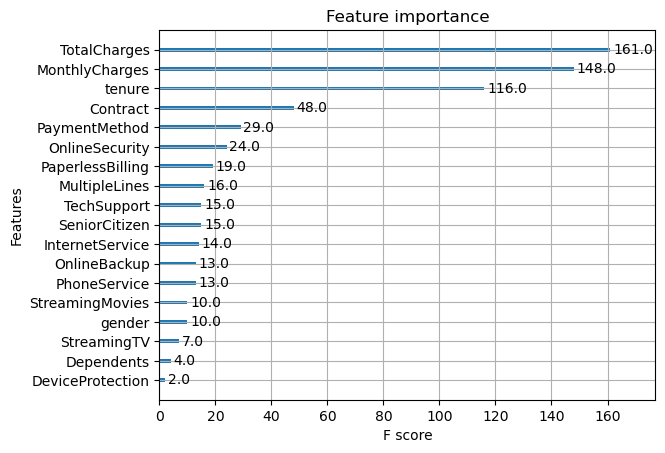

In [458]:
xgb.plot_importance(model)
plt.show()

### Metod 2. med hjälp av att räkna viktigheten av attributen och sedan plotta resultatet i en stapeldiagram med hjälp av plt.bar()

In [376]:
importance = model.feature_importances_

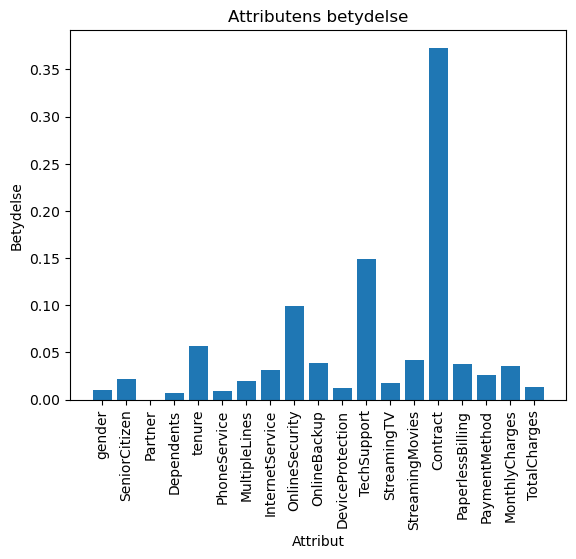

In [465]:
plt.bar(range(len(importance)), importance)
plt.xticks(range(len(importance)), X_train.columns, rotation='vertical')
plt.xlabel('Attribut')
plt.ylabel('Betydelse')
plt.title('Attributens betydelse')
plt.show()

## Två metoder som jag har använt för att kolla vilka attribut har störst påverkan, visar inte samma resultat, i metod 1. visar att totalcharges har störst påverkan men i andra metoden visar att Contract har störst påverkan.
## Efter flera research på nätet säger "model.feature_importances_"

# Confusion Matrix

In [398]:
confusion_matrix = confusion_matrix(y_test, y_pred)

In [399]:
print(confusion_matrix)

[[914 112]
 [176 207]]


In [405]:
matrix = classification_report(y_test, y_pred)

In [407]:
print(f'Classificiering report för matrix:\n', matrix)

Classificiering report för matrix:
               precision    recall  f1-score   support

           0       0.84      0.89      0.86      1026
           1       0.65      0.54      0.59       383

    accuracy                           0.80      1409
   macro avg       0.74      0.72      0.73      1409
weighted avg       0.79      0.80      0.79      1409



## Sannolikheten för hur modellen gör prediktioner 

In [426]:
probabilities = model.predict_proba(X_test)

In [427]:
print('Sannolikheten för hur modellen gör prdiktioner:\n', probabilities)

Sannolikheten för hur modellen gör prdiktioner:
 [[0.60472953 0.39527047]
 [0.4980979  0.5019021 ]
 [0.7004659  0.2995341 ]
 ...
 [0.67675    0.32325   ]
 [0.8648252  0.1351748 ]
 [0.44953007 0.55046993]]


## Var modellen har haft svårt att göra en korrekt prediktion

In [433]:
misclassified_examples = []

for i in range(len(y_test)):
    if y_test[i] != y_pred[i]:
        misclassified_examples.append(i)

misclassified_samples = X_test.iloc[misclassified_examples]

In [434]:
print('Modellen har svårigheter i: \n', misclassified_samples)

Modellen har svårigheter i: 
       gender  SeniorCitizen  Partner  Dependents  tenure  PhoneService  \
3          0              1        0           0       1             1   
4          0              0        0           0       9             1   
7          1              0        0           0      33             1   
8          0              0        0           0       1             1   
10         1              0        0           1       2             1   
...      ...            ...      ...         ...     ...           ...   
1398       1              1        1           0      51             1   
1401       0              1        1           0      32             1   
1404       1              0        0           0      25             1   
1406       1              0        0           0      10             1   
1408       0              1        0           0      41             1   

      MultipleLines  InternetService  OnlineSecurity  OnlineBackup  \
3          

# Vilka typer av fel den gör ?

### Felaktiga positiva prdiktioner

In [435]:
false_positives = []
correct_positives = []

for i in range(len(y_test)):
    if y_test[i] == 1 and y_pred[i] == 1:
        correct_positives.append(i)
    elif y_test[i] == 0 and y_pred[i] == 1:
        false_positives.append(i)

In [444]:
print('Listan över var modellen har gjort felaktiga positiva prediktioner:\n', false_positives)

Listan över var modellen har gjort felaktiga positiva prediktioner:
 [3, 10, 21, 34, 42, 84, 98, 128, 133, 137, 178, 182, 186, 192, 206, 216, 217, 232, 241, 263, 289, 296, 299, 307, 309, 314, 317, 332, 347, 349, 352, 358, 402, 411, 469, 481, 486, 493, 497, 511, 515, 530, 546, 550, 554, 564, 565, 574, 580, 591, 609, 611, 614, 625, 645, 666, 674, 696, 707, 722, 730, 743, 778, 808, 811, 828, 834, 842, 860, 861, 875, 893, 896, 926, 936, 941, 956, 958, 979, 994, 995, 1004, 1005, 1007, 1030, 1036, 1041, 1053, 1056, 1058, 1067, 1084, 1085, 1142, 1143, 1160, 1173, 1187, 1224, 1237, 1239, 1250, 1260, 1263, 1289, 1299, 1332, 1336, 1338, 1347, 1358, 1372, 1377, 1380, 1384, 1393, 1404, 1408]


In [437]:
false_positive_examples = X_test.iloc[false_positives]
correct_positive_examples = X_test.iloc[correct_positives]

In [445]:
print('Exemple för dem felaktiga positiva prdiktioner:\n',false_positive_examples)

Exemple för dem felaktiga positiva prdiktioner:
       gender  SeniorCitizen  Partner  Dependents  tenure  PhoneService  \
3          0              1        0           0       1             1   
10         1              0        0           1       2             1   
21         1              1        0           0      17             1   
34         1              0        0           0       9             1   
42         0              1        0           0       6             0   
...      ...            ...      ...         ...     ...           ...   
1380       0              1        0           0       3             1   
1384       1              0        0           0       3             1   
1393       1              1        0           0      45             1   
1404       1              0        0           0      25             1   
1408       0              1        0           0      41             1   

      MultipleLines  InternetService  OnlineSecurity  OnlineBa

### Felaktiga negativa prediktioner

In [439]:
false_negative = []
correct_negative = []

for i in range(len(y_test)):
    if y_test[i] == 0 and y_pred[i] == 0:
        correct_negative.append(i)
    elif y_test[i] == 1 and y_pred[i] == 0:
        false_negative.append(i)

In [447]:
print('Listan över var modellen har gjort felaktiga negativa prediktioner:\n', false_negative)

Listan över var modellen har gjort felaktiga negativa prediktioner:
 [4, 7, 8, 25, 28, 43, 46, 50, 53, 54, 58, 69, 72, 101, 105, 138, 141, 148, 165, 166, 179, 185, 190, 196, 197, 205, 233, 242, 245, 248, 259, 260, 269, 276, 318, 319, 322, 323, 324, 343, 344, 353, 357, 366, 368, 385, 408, 430, 432, 433, 437, 455, 468, 472, 476, 489, 499, 506, 547, 555, 562, 571, 575, 577, 593, 596, 600, 612, 616, 621, 626, 647, 654, 659, 661, 662, 672, 679, 681, 704, 705, 708, 710, 717, 749, 753, 755, 760, 779, 783, 786, 791, 803, 807, 809, 810, 812, 814, 815, 823, 824, 841, 852, 854, 856, 857, 867, 881, 887, 899, 911, 914, 919, 921, 922, 932, 942, 943, 945, 976, 989, 993, 1008, 1010, 1021, 1024, 1031, 1033, 1046, 1047, 1049, 1070, 1074, 1105, 1115, 1116, 1120, 1128, 1144, 1158, 1165, 1166, 1169, 1196, 1198, 1199, 1209, 1225, 1232, 1235, 1236, 1242, 1245, 1249, 1259, 1264, 1265, 1272, 1276, 1284, 1287, 1291, 1295, 1301, 1307, 1319, 1324, 1341, 1342, 1360, 1369, 1376, 1386, 1395, 1398, 1401, 1406]


In [440]:
false_negative_examples = X_test.iloc[false_negative]
correct_negative_examples = X_test.iloc[correct_negative]

In [441]:
print('exemple för dem felaktiga negativa prdiktioner:\n',false_negative_examples)

exemple för dem felaktiga negativa prdiktioner:
       gender  SeniorCitizen  Partner  Dependents  tenure  PhoneService  \
4          0              0        0           0       9             1   
7          1              0        0           0      33             1   
8          0              0        0           0       1             1   
25         0              0        1           0      52             1   
28         0              1        1           0      68             1   
...      ...            ...      ...         ...     ...           ...   
1386       0              0        0           0       3             1   
1395       1              0        0           0      25             1   
1398       1              1        1           0      51             1   
1401       0              1        1           0      32             1   
1406       1              0        0           0      10             1   

      MultipleLines  InternetService  OnlineSecurity  OnlineBa